# test_companion

Задание :  
  
Вам нужно построить скоринговую модель (модель прогноза и принятия решений), для того, чтобы автоматически решать - кому из клиентов выдавать кредит, а кому нет.  
  
Модель должна предсказывать тип кредита ("Хороший" или "Плохой") при помощи информации о клиенте (Пол, Возраст) и информации о кредитной истории клиента (Просрочки по его историческим кредитам).  
  
Модель может быть составлена в любом виде (рекомендуемый вариант - Логистическая регрессия).  
  
Желательно сделать обучение модели на одной части данных, а тестирование модели на другой части, и показать метрики качества модели (рекомендуемый вариант - ROC-AUC, Gini index).  
  
Результат :  
  
Отправить результаты нужно в виде :  
  
1) Код создания модели (рекомендуемый вариан т - jupyter notebook, .ipynb)  
  
2) Результат тестирования в любом формате  

## Импорт библиотек

In [109]:
!pip install imbalanced-learn

In [110]:
import pandas as pd
import re as re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



## Загрузка данных


In [111]:
credit_info = pd.read_excel("Credit Info.xlsx")
customer_info = pd.read_excel("Customer Info.xlsx")
history_info = pd.read_excel("History Info.xlsx")


### credit_info

In [112]:
credit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Credit ID          1000 non-null   int64         
 1   Customer ID        1000 non-null   int64         
 2   Loan Created Date  1000 non-null   datetime64[ns]
 3   Type Credit        1000 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 31.4+ KB


In [113]:
credit_info.head()

,Credit ID,Customer ID,Loan Created Date,Type Credit
0,857000,483,2020-09-05,Normal
1,695553,843,2021-05-20,Normal
2,992484,1801,2021-07-02,Normal
3,964325,296,2021-09-25,Normal
4,602834,694,2021-04-21,Normal


In [114]:
credit_info.describe(include = 'all', datetime_is_numeric=True)

,Credit ID,Customer ID,Loan Created Date,Type Credit
count,1000.000000,1000.000000,1000,1000
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,Normal
freq,NaN,NaN,NaN,897
mean,503401.862000,979.259000,2021-06-29 05:03:50.400000,NaN
min,4639.000000,1.000000,2020-01-01 00:00:00,NaN
25%,255464.250000,476.000000,2020-09-26 18:00:00,NaN
50%,498307.000000,974.500000,2021-07-10 12:00:00,NaN
75%,748615.500000,1469.000000,2022-03-16 00:00:00,NaN
max,999987.000000,1997.000000,2022-12-30 00:00:00,NaN


In [115]:
credit_info.duplicated().sum()

0

Credit ID: Уникальный идентификатор кредита.    
Customer ID: Уникальный идентификатор клиента.  
Loan Created Date: Дата создания кредита.  
Type Credit: Тип кредита, который может быть либо "Normal", либо "Problem".  

Пропуски отсутствуют, дубликаты отсутствуют. Минимальная дата 2020-01-01 0:00:00	последняя дата 2022-12-30 00:00:00. Два уникальных значения в типах кредита	

### customer_info

In [116]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Customer ID  798 non-null    int64         
 1   Sex          798 non-null    object        
 2   Birthday     798 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 18.8+ KB


In [117]:
customer_info.describe(include = 'all', datetime_is_numeric=True)

,Customer ID,Sex,Birthday
count,798.000000,798,798
unique,NaN,2,NaN
top,NaN,Man,NaN
freq,NaN,412,NaN
mean,969.021303,NaN,1971-07-13 02:51:25.714285712
min,1.000000,NaN,1940-01-06 00:00:00
25%,453.250000,NaN,1955-05-27 12:00:00
50%,966.500000,NaN,1971-02-15 00:00:00
75%,1460.500000,NaN,1987-08-10 18:00:00
max,1997.000000,NaN,2005-12-16 00:00:00


In [118]:
customer_info.duplicated().sum()

0

In [119]:
customer_info.head()

,Customer ID,Sex,Birthday
0,1,Man,2000-07-14
1,3,Man,2003-03-04
2,16,Man,1989-03-04
3,17,Woman,1956-01-17
4,18,Man,1993-10-23


Customer ID: Уникальный идентификатор клиента.    
Sex - пол   
Birthday - день рождение клиента  

Пропуски отсутствуют, дубликаты отсутствуют. Минимальная дата дня рождения 1940-01-06 00:00:00	последняя дата 2005-12-16 00:00:00(По каждому клиенту можно посчитать возраст на момент выдачи кредита). Пол только два значение Man and Woman


### history_info

In [120]:
history_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   History Note ID  1500 non-null   int64
 1   Customer ID      1500 non-null   int64
 2   Overdues         1500 non-null   int64
dtypes: int64(3)
memory usage: 35.3 KB


In [121]:
history_info

,History Note ID,Customer ID,Overdues
0,0,499,0
1,1,461,0
2,2,516,0
3,3,138,0
4,4,1770,0
...,...,...,...
1495,1495,1287,0
1496,1496,194,86
1497,1497,48,0
1498,1498,686,0


In [122]:
history_info.describe(include = 'all', datetime_is_numeric=True)

,History Note ID,Customer ID,Overdues
count,1500.000000,1500.000000,1500.000000
mean,749.500000,940.132667,11.480000
std,433.157015,586.060076,23.990386
min,0.000000,1.000000,0.000000
25%,374.750000,431.000000,0.000000
50%,749.500000,918.500000,0.000000
75%,1124.250000,1449.250000,0.000000
max,1499.000000,1997.000000,90.000000


In [123]:
history_info.query("`Customer ID` == 201")

,History Note ID,Customer ID,Overdues
282,282,201,90
832,832,201,63
1178,1178,201,0
1211,1211,201,90
1229,1229,201,0
1426,1426,201,87
1436,1436,201,0


In [124]:
credit_info.query("`Customer ID` == 201")

,Credit ID,Customer ID,Loan Created Date,Type Credit
975,531107,201,2021-03-14,Problem


In [125]:
history_info.duplicated().sum()

0

History Note ID	 - Это уникальный идентификатор записи в истории кредитования. Каждая запись представляет собой конкретный случай, когда клиент имел просрочку по оплате кредита.  
  
Customer ID	-  Это уникальный идентификатор клиента. Этот идентификатор связывает запись просрочки с конкретным клиентом.  
    
Overdues - Этот признак представляет собой количество дней просрочек, которые были у данного клиента в данном случае. В контексте этого файла, одна запись соответствует  просрочке. 

Пропуски отсутствуют, дубликаты отсутствуют. 

## Объединение данных

In [126]:
history_info.tail()

,History Note ID,Customer ID,Overdues
1495,1495,1287,0
1496,1496,194,86
1497,1497,48,0
1498,1498,686,0
1499,1499,510,0


In [127]:
history_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   History Note ID  1500 non-null   int64
 1   Customer ID      1500 non-null   int64
 2   Overdues         1500 non-null   int64
dtypes: int64(3)
memory usage: 35.3 KB


In [128]:
# Группировка данных истории по ID клиента, подсчет общего числа просрочек и количества записей о просрочках
overdues_sum = history_info.groupby('Customer ID')['Overdues'].sum().reset_index().rename(columns={'Overdues': 'Overdues_Sum'})
overdues_count = history_info.groupby('Customer ID').size().reset_index().rename(columns={0: 'Overdues_Count'})

# Объединение информации о сумме и количестве просрочек
overdues = pd.merge(overdues_sum, overdues_count, on="Customer ID")

# Объединение информации о клиентах с историей просрочек
customer_info = pd.merge(customer_info, overdues, on="Customer ID", how='left')

# Объединение данных кредитов и информации о клиентах
data = pd.merge(credit_info, customer_info, on="Customer ID")




In [129]:
data.head()

,Credit ID,Customer ID,Loan Created Date,Type Credit,Sex,Birthday,Overdues_Sum,Overdues_Count
0,857000,483,2020-09-05,Normal,Woman,1959-06-15,NaN,NaN
1,695553,843,2021-05-20,Normal,Man,1960-09-25,32.0,1.0
2,755310,843,2020-08-24,Normal,Man,1960-09-25,32.0,1.0
3,992484,1801,2021-07-02,Normal,Woman,1982-12-24,32.0,1.0
4,964325,296,2021-09-25,Normal,Man,1982-08-17,NaN,NaN


### Обобщение


Исходя из текущего описания данных, у нас нет прямого способа связать просрочки с конкретными кредитами. В нашей таблице history_info у нас есть информация о просрочках ('Overdues') и идентификаторе клиента ('Customer ID'), но нет уникального идентификатора кредита ('Credit ID') для связи с просрочками.  
  
Если бы у нас была такая информация, мы могли бы использовать ее для более точного объединения данных. Например, если бы у нас был столбец 'Credit ID' в таблице history_info, мы могли бы просто выполнить операцию объединения (merge) с использованием идентификатора кредита.  
  
Мы вынуждены предположить, что общая история просрочек клиента применима ко всем его кредитам.  

## Предобработка

In [130]:
data.head()

,Credit ID,Customer ID,Loan Created Date,Type Credit,Sex,Birthday,Overdues_Sum,Overdues_Count
0,857000,483,2020-09-05,Normal,Woman,1959-06-15,NaN,NaN
1,695553,843,2021-05-20,Normal,Man,1960-09-25,32.0,1.0
2,755310,843,2020-08-24,Normal,Man,1960-09-25,32.0,1.0
3,992484,1801,2021-07-02,Normal,Woman,1982-12-24,32.0,1.0
4,964325,296,2021-09-25,Normal,Man,1982-08-17,NaN,NaN


In [131]:
# Заполнение пропущенных значений в просрочках
data['Overdues_Sum'] = data['Overdues_Sum'].fillna(0)
data['Overdues_Count'] = data['Overdues_Count'].fillna(0)
data['Overdues_Sum'] = data['Overdues_Sum'].astype(int)
data['Overdues_Count'] = data['Overdues_Count'].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Credit ID          1000 non-null   int64         
 1   Customer ID        1000 non-null   int64         
 2   Loan Created Date  1000 non-null   datetime64[ns]
 3   Type Credit        1000 non-null   object        
 4   Sex                1000 non-null   object        
 5   Birthday           1000 non-null   datetime64[ns]
 6   Overdues_Sum       1000 non-null   int64         
 7   Overdues_Count     1000 non-null   int64         
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 70.3+ KB


In [132]:
data.drop_duplicates().duplicated().sum()

0

In [133]:
#Приведем название столбцов к змеиному регистру
data.columns = [re.sub(r"\b([A-Z])", r"_\1", col).lower() for col in data.columns]
data.columns = [col.lstrip("_") for col in data.columns]
data.columns = [re.sub(r'\s_', '_', i) for i in data.columns]

data.columns

Index(['credit_id', 'customer_id', 'loan_created_date', 'type_credit', 'sex',
       'birthday', 'overdues_sum', 'overdues_count'],
      dtype='object')

In [134]:
data.describe(include='all', datetime_is_numeric=True)

,credit_id,customer_id,loan_created_date,type_credit,sex,birthday,overdues_sum,overdues_count
count,1000.000000,1000.000000,1000,1000,1000,1000,1000.000000,1000.00000
unique,NaN,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,NaN,Normal,Man,NaN,NaN,NaN
freq,NaN,NaN,NaN,897,519,NaN,NaN,NaN
mean,503401.862000,979.259000,2021-06-29 05:03:50.400000,NaN,NaN,1971-11-03 09:50:24,21.246000,1.85900
min,4639.000000,1.000000,2020-01-01 00:00:00,NaN,NaN,1940-01-06 00:00:00,0.000000,0.00000
25%,255464.250000,476.000000,2020-09-26 18:00:00,NaN,NaN,1956-01-21 00:00:00,0.000000,1.00000
50%,498307.000000,974.500000,2021-07-10 12:00:00,NaN,NaN,1971-03-06 00:00:00,0.000000,2.00000
75%,748615.500000,1469.000000,2022-03-16 00:00:00,NaN,NaN,1987-08-20 00:00:00,34.000000,3.00000
max,999987.000000,1997.000000,2022-12-30 00:00:00,NaN,NaN,2005-12-16 00:00:00,330.000000,7.00000


In [135]:
#Удалим неинформативные столбцы, не нужные для модели credit_id, customer_id
data = data.drop(['credit_id', 'customer_id'], axis=1).copy()
data.head()



,loan_created_date,type_credit,sex,birthday,overdues_sum,overdues_count
0,2020-09-05,Normal,Woman,1959-06-15,0,0
1,2021-05-20,Normal,Man,1960-09-25,32,1
2,2020-08-24,Normal,Man,1960-09-25,32,1
3,2021-07-02,Normal,Woman,1982-12-24,32,1
4,2021-09-25,Normal,Man,1982-08-17,0,0


### Обобщение

1. Обработали пропуски в overdues, замнили на 0
2. Удалили неинформативные столбцы, не нужные для модели credit_id, customer_id
3. Привели столбцы к змеиному регистру
4. Дубликаты отсутствуют как и пропуски

## Анализ данных и добавление дополнительных призанков

In [136]:
# Возраст клиента на момент создания кредит
data['age_at_loan'] = (data['loan_created_date'] - data['birthday']).dt.days // 365
data = data.drop(['birthday',], axis=1).copy()


In [137]:
# Берем максимальную дату из loan_created_date
max_date = data['loan_created_date'].max()

# Вычисление количества дней с момента выдачи кредита
data['days_since_loan'] = (max_date - data['loan_created_date']).dt.days
data = data.drop('loan_created_date', axis=1)


In [138]:
# Среднее количество дней просрочки на одну просрочку
data['average_overdue'] = data['overdues_sum'] / data['overdues_count']
data['average_overdue'].fillna(0, inplace=True)


In [139]:
#кодирование категориального признака 'sex'
data['sex'] = data['sex'].map({'Woman': 0, 'Man': 1})
data.head()

,type_credit,sex,overdues_sum,overdues_count,age_at_loan,days_since_loan,average_overdue
0,Normal,0,0,0,61,846,0.0
1,Normal,1,32,1,60,589,32.0
2,Normal,1,32,1,59,858,32.0
3,Normal,0,32,1,38,546,32.0
4,Normal,1,0,0,39,461,0.0


In [140]:
# целевой признак 'type_credit' содержит категории "Normal" и "Problem", мы можете выполнить бинарное кодирование этого признака
data['type_credit'] = data['type_credit'].replace({'Normal': 0, 'Problem': 1})


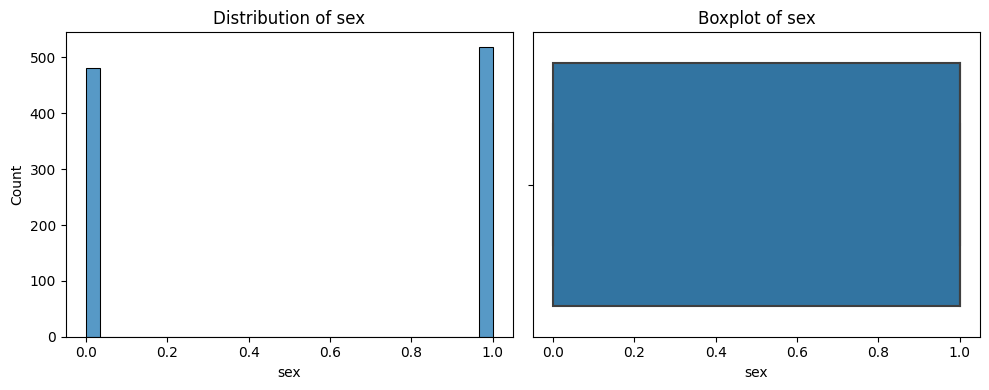

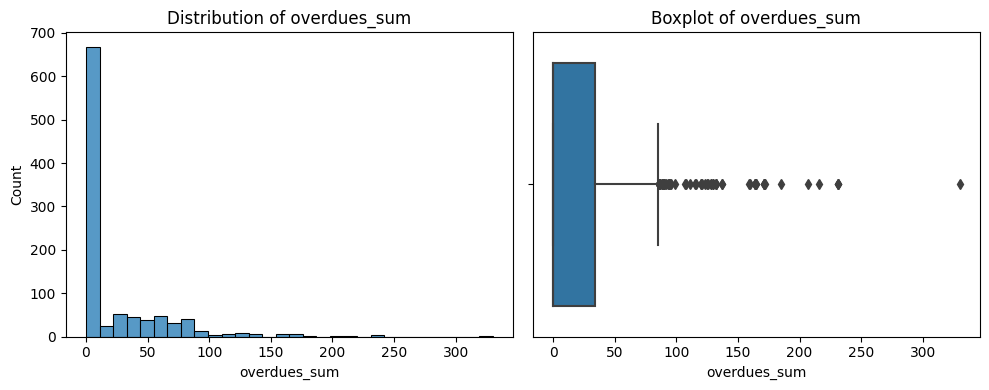

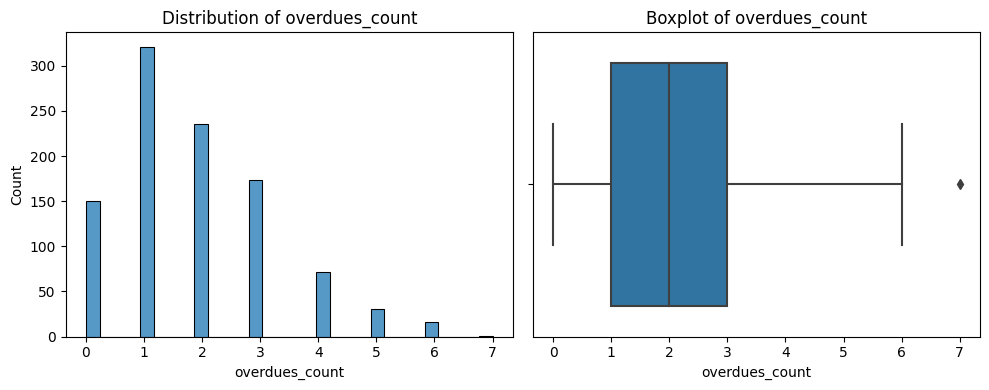

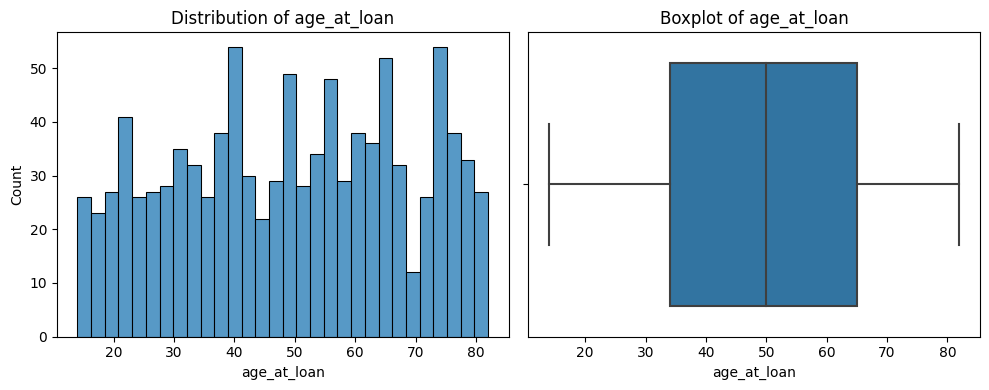

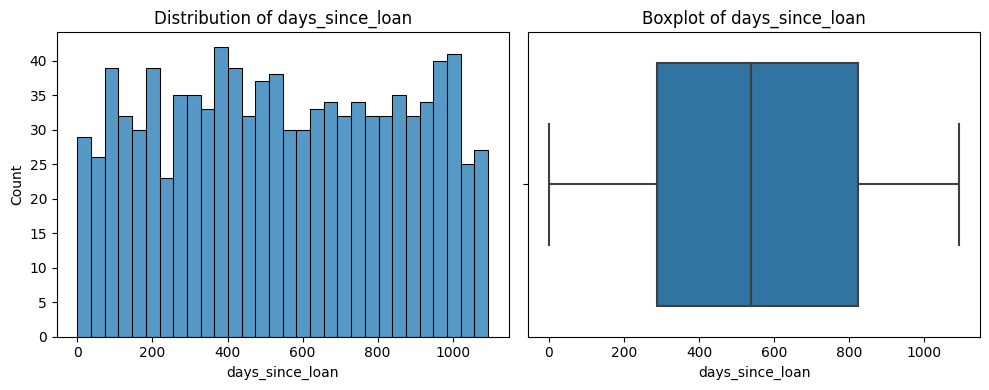

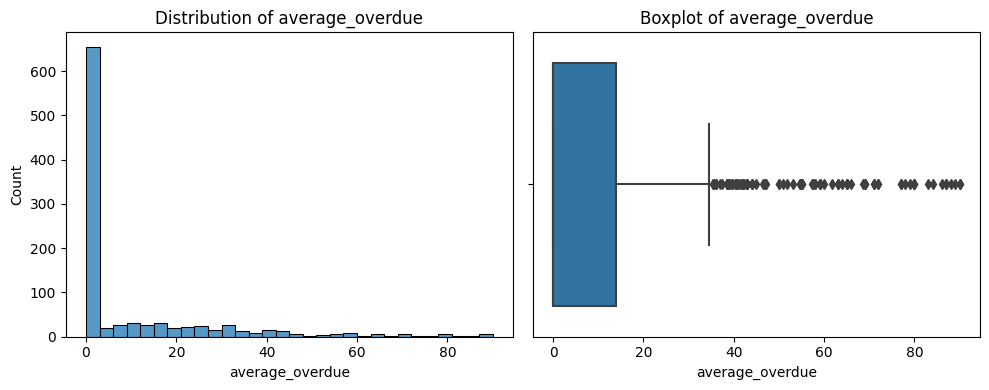

In [141]:
# Список всех числовых столбцов, кроме целевой переменной
features = [col for col in data.select_dtypes(include=[np.number]).columns if col != 'type_credit']

# Построение графика для каждого признака
for feature in features:
    plt.figure(figsize=(10, 4))
    
    # Построение гистограммы
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    
    # Построение ящика с усами для оценки выбросов
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
    
    plt.tight_layout()
    plt.show() 



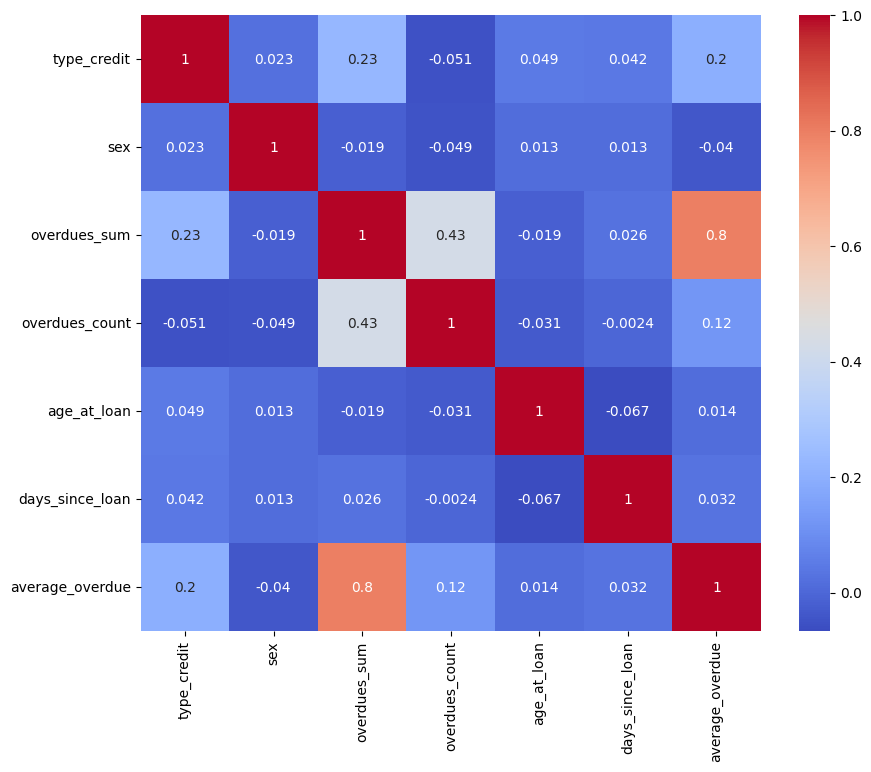

In [142]:
# Проверим корреляцию
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


Мультиколлинеарность может вызвать проблемы в некоторых статистических моделях (например, линейной регрессии), так как они предполагают, что признаки независимы друг от друга. В этих случаях удаление одного из коррелирующих признаков может помочь.  
  
Однако в контексте многих современных алгоритмов машинного обучения (например, градиентный бустинг или случайный лес), мультиколлинеарность не является большой проблемой, и удаление признаков может привести к потере информации.  

In [143]:
data.groupby('sex')['type_credit'].count()# рассмотрим целевой признак

sex
0    481
1    519
Name: type_credit, dtype: int64

In [144]:
data.groupby('sex')['type_credit'].sum()# количество проблемных кредитов

sex
0    46
1    57
Name: type_credit, dtype: int64

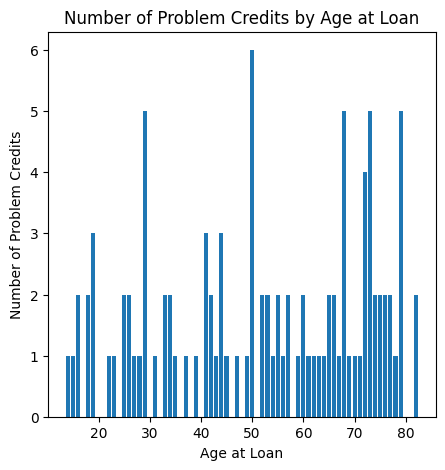

In [145]:
problem_credits_per_age = data.groupby('age_at_loan')['type_credit'].sum()# количество проблемных кредитов по возрасту

plt.figure(figsize=(5, 5))
plt.bar(problem_credits_per_age.index, problem_credits_per_age.values)
plt.xlabel('Age at Loan')
plt.ylabel('Number of Problem Credits')
plt.title('Number of Problem Credits by Age at Loan')
plt.show()

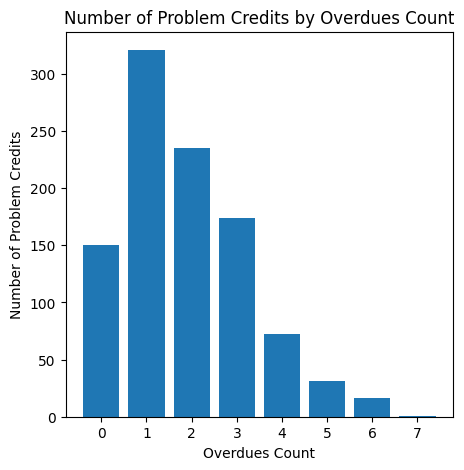

In [146]:
problem_credits_per_overdues = data.groupby('overdues_count')['type_credit'].count()

plt.figure(figsize=(5, 5))
plt.bar(problem_credits_per_overdues.index, problem_credits_per_overdues.values)
plt.xlabel('Overdues Count')
plt.ylabel('Number of Problem Credits')
plt.title('Number of Problem Credits by Overdues Count')
plt.show()


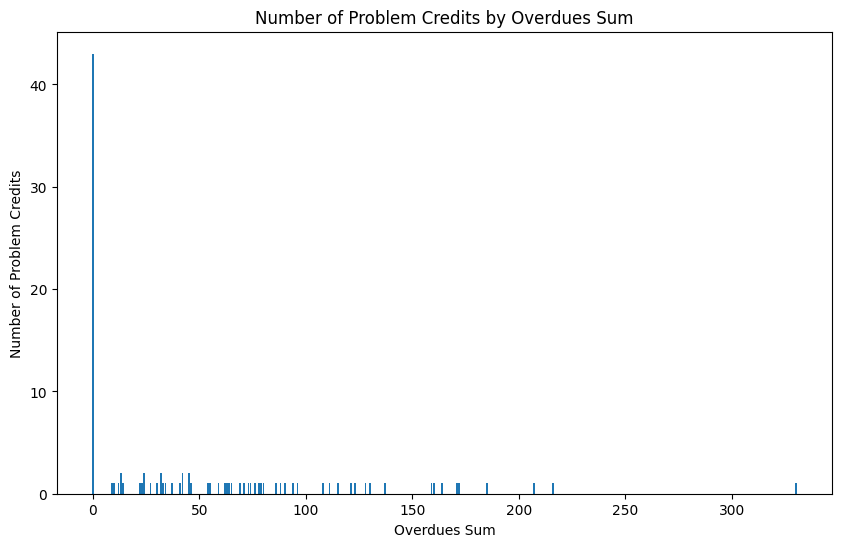

In [147]:
problem_credits_per_overdues_sum = data.groupby('overdues_sum')['type_credit'].sum()

plt.figure(figsize=(10, 6))
plt.bar(problem_credits_per_overdues_sum.index, problem_credits_per_overdues_sum.values)
plt.xlabel('Overdues Sum')
plt.ylabel('Number of Problem Credits')
plt.title('Number of Problem Credits by Overdues Sum')
plt.show()


### Вывод 

1. У большинства клиентов отсутствуют просрочки по платежам (то есть 'overdues_sum' равен 0). Это нормально и соответствует общей динамике кредитования: большинство клиентов погашают свои кредиты в срок, а проблемные кредиты — это относительно редкий случай.
2. Больше всего проблемных кредитов у 50-летних
3. Клиенты, которые допустили хотя бы одну просрочку, могут стать менее дисциплинированными в погашении кредита, что увеличивает вероятность проблем с кредитом.
4. Присутствуют выбросы

## Основная часть 

In [148]:
data

,type_credit,sex,overdues_sum,overdues_count,age_at_loan,days_since_loan,average_overdue
0,0,0,0,0,61,846,0.000000
1,0,1,32,1,60,589,32.000000
2,0,1,32,1,59,858,32.000000
3,0,0,32,1,38,546,32.000000
4,0,1,0,0,39,461,0.000000
...,...,...,...,...,...,...,...
995,0,1,0,1,22,977,0.000000
996,0,1,79,6,28,441,13.166667
997,1,1,0,0,64,1005,0.000000
998,0,0,0,1,31,62,0.000000


 ### Разобьем данные на выборки

In [149]:
# отделим 20% данных для тестовой выборки выборки (для проверки модели)
target = data['type_credit']
features = data.drop(['type_credit'] , axis=1)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=453)

In [150]:
# отделим 25% данных(от other) для разделения на обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(
    features_other, target_other, test_size=0.25, random_state=453)

In [151]:
print('Размер обучающей выборки', len(features_train))
print('Размер валидационной выборки', len(features_valid))
print('Размер тестовой выборки', len(features_test))

Размер обучающей выборки 600
Размер валидационной выборки 200
Размер тестовой выборки 200


### Масштабирование

In [152]:
features.columns

Index(['sex', 'overdues_sum', 'overdues_count', 'age_at_loan',
       'days_since_loan', 'average_overdue'],
      dtype='object')

In [153]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns = features.columns)
features_valid = pd.DataFrame(scaler.transform(features_valid), columns = features.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = features.columns)

In [154]:
features_test

,sex,overdues_sum,overdues_count,age_at_loan,days_since_loan,average_overdue
0,0.932287,0.969643,0.093744,0.358781,-0.348477,1.148507
1,0.932287,-0.539007,-0.627362,-0.345774,0.112665,-0.547296
2,0.932287,-0.539007,-0.627362,1.280123,0.083843,-0.547296
3,0.932287,-0.539007,-0.627362,-0.887740,0.810781,-0.547296
4,-1.072631,-0.539007,-1.348468,-0.725150,-1.533353,-0.547296
...,...,...,...,...,...,...
195,-1.072631,-0.539007,-0.627362,-1.429706,0.125474,-0.547296
196,0.932287,-0.539007,-0.627362,-1.212919,0.894043,-0.547296
197,-1.072631,-0.539007,-1.348468,-1.700689,-0.502190,-0.547296
198,-1.072631,-0.539007,-0.627362,-0.725150,-1.222724,-0.547296


### Дисбаланс классов

In [155]:
data.groupby('type_credit')['type_credit'].count()# рассмотрим целевой признак. Каждый 9 кредит проблемный. Наблюдается дисбаланс классов

type_credit
0    897
1    103
Name: type_credit, dtype: int64

В большинстве моделей есть параметр для взвешивания классов во время обучения модели. Например, в случае логистической регрессии, мы можем установить параметр class_weight='balanced', и модель автоматически придаст больший вес миноритарному классу.

### Обучение и выбор моделей

In [156]:
#для удобства вывода в дальнейшем - соберем показатели в списки

tabl_model = []
tabl_prec = []
tabl_not = []
tabl_roc_auc = []
tabl_gini = []


### class_weight='balanced'

#### CatBoostClassifier

In [157]:
model = CatBoostClassifier(
    iterations=1000, 
    depth=5, 
    learning_rate=0.1, 
    custom_loss=['AUC', 'Accuracy'],
    random_seed=453,
    verbose=False
)

model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))


F1: 0.16666666666666666
AUC_ROC = 0.605

Gini Index = 0.210



In [158]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('class_weight')


#### LogisticRegression

In [159]:
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=453, class_weight='balanced')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.19047619047619044
AUC_ROC = 0.674

Gini Index = 0.347



In [160]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('class_weight')

#### Модель Дерево решений 

In [161]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth, random_state=453, class_weight='balanced') 
	model.fit(features_train, target_train) 
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1 лучшей модели: 0.20833333333333334
max_depth лучшей модели: DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=453)
AUC_ROC = 0.685

Gini Index = 0.370

CPU times: user 89.2 ms, sys: 0 ns, total: 89.2 ms
Wall time: 88.9 ms


In [162]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('class_weight')

#### Модель случайный лес

In [163]:
%%time
1 + 1

model = RandomForestClassifier(class_weight='balanced', max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30,random_state=453)

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.1379310344827586
AUC_ROC = 0.685

Gini Index = 0.370

CPU times: user 67.4 ms, sys: 3.21 ms, total: 70.6 ms
Wall time: 74.9 ms


In [164]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('class_weight')


In [165]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,DecisionTreeClassifier,0.21,0.69,0.37,class_weight
1,RandomForestClassifier,0.14,0.69,0.37,class_weight
2,LogisticRegression,0.19,0.67,0.35,class_weight
3,CatBoostClassifier,0.17,0.61,0.21,class_weight


### upsampling. Увеличение выборки

In [166]:
oversample = SMOTE(random_state=453)
features_upsampled, target_upsampled = oversample.fit_resample(features_train, target_train)
print('Размер увеличенной валидационной выборки', len(features_upsampled))

Размер увеличенной валидационной выборки 1078


#### Модель Логистическая регрессия

In [167]:
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=453, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.17391304347826086
AUC_ROC = 0.634

Gini Index = 0.267



In [168]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('upsampling')

#### Модель Дерево решений 

In [169]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth)
	model.fit(features_upsampled, target_upsampled)
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1 лучшей модели: 0.22580645161290322
max_depth лучшей модели: DecisionTreeClassifier(max_depth=6)
AUC_ROC = 0.705

Gini Index = 0.410

CPU times: user 98.2 ms, sys: 407 µs, total: 98.6 ms
Wall time: 100 ms


In [170]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('upsampling')

#### Модель случайный лес. 

In [171]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=453)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.10526315789473685
AUC_ROC = 0.680

Gini Index = 0.359

CPU times: user 87.4 ms, sys: 654 µs, total: 88 ms
Wall time: 90.5 ms


In [172]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('upsampling')

#### CatBoostClassifier

In [173]:
model = CatBoostClassifier(
    iterations=1000, 
    depth=5, 
    learning_rate=0.1, 
    custom_loss=['AUC', 'Accuracy'],
    random_seed=453,
    verbose=False
)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

auc_roc = roc_auc_score(target_valid, predicted_valid)
print('ROC-AUC:', auc_roc)

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.1
ROC-AUC: 0.5069124423963133
Gini Index = 0.014



In [174]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('upsampling')

In [175]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,DecisionTreeClassifier,0.23,0.71,0.41,upsampling
1,DecisionTreeClassifier,0.21,0.69,0.37,class_weight
2,RandomForestClassifier,0.14,0.69,0.37,class_weight
3,RandomForestClassifier,0.11,0.68,0.36,upsampling
4,LogisticRegression,0.19,0.67,0.35,class_weight
5,LogisticRegression,0.17,0.63,0.27,upsampling
6,CatBoostClassifier,0.17,0.61,0.21,class_weight
7,CatBoostClassifier,0.10,0.51,0.01,upsampling


### downsampling. Уменьшение выборки

In [176]:
downsample = RandomUnderSampler(random_state=12345)

In [177]:
features_downsampled, target_downsampled = downsample.fit_resample(features_train, target_train)

In [178]:
print('Размер уменьшенной валидационной выборки', len(features_downsampled))

Размер уменьшенной валидационной выборки 122


#### Модель Логистическая регрессия

In [179]:
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=453, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.19607843137254902
AUC_ROC = 0.707

Gini Index = 0.413



In [180]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('downsampled')

#### Модель Дерево решений 

In [181]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) 
	model.fit(features_downsampled, target_downsampled) 
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1 лучшей модели: 0.2
max_depth лучшей модели: DecisionTreeClassifier(max_depth=1)
AUC_ROC = 0.595

Gini Index = 0.190

CPU times: user 68.8 ms, sys: 0 ns, total: 68.8 ms
Wall time: 70.9 ms


In [182]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('downsampled')

#### Модель случайный лес

In [183]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.14678899082568805
AUC_ROC = 0.517

Gini Index = 0.035

CPU times: user 59.7 ms, sys: 2.1 ms, total: 61.8 ms
Wall time: 62.7 ms


In [184]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('downsampled')

#### CatBoostClassifier

In [185]:
model = CatBoostClassifier(
    iterations=1000, 
    depth=5, 
    learning_rate=0.1, 
    custom_loss=['AUC', 'Accuracy'],
    random_seed=453,
    verbose=False
)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.11320754716981131
AUC_ROC = 0.514

Gini Index = 0.028



In [186]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('downsampled')

In [187]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,DecisionTreeClassifier,0.23,0.71,0.41,upsampling
1,LogisticRegression,0.20,0.71,0.41,downsampled
2,DecisionTreeClassifier,0.21,0.69,0.37,class_weight
3,RandomForestClassifier,0.14,0.69,0.37,class_weight
4,RandomForestClassifier,0.11,0.68,0.36,upsampling
5,LogisticRegression,0.19,0.67,0.35,class_weight
6,LogisticRegression,0.17,0.63,0.27,upsampling
7,CatBoostClassifier,0.17,0.61,0.21,class_weight
8,DecisionTreeClassifier,0.20,0.60,0.19,downsampled
9,RandomForestClassifier,0.15,0.52,0.03,downsampled


### Изменение порога клалификации

Граница, где заканчивается отрицательный класс и начинается положительный, называется порогом (threshold). По умолчанию он равен 0.5, но его можно поменять.

#### Модель Логистическая регрессия

In [188]:
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=453, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.3, 0.01):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

Порог = 0.00 | Точность = 0.070, Полнота = 1.000, F1-мера = 0.131
Порог = 0.01 | Точность = 0.070, Полнота = 1.000, F1-мера = 0.131
Порог = 0.02 | Точность = 0.070, Полнота = 1.000, F1-мера = 0.131
Порог = 0.03 | Точность = 0.070, Полнота = 1.000, F1-мера = 0.131
Порог = 0.04 | Точность = 0.070, Полнота = 1.000, F1-мера = 0.131
Порог = 0.05 | Точность = 0.070, Полнота = 1.000, F1-мера = 0.131
Порог = 0.06 | Точность = 0.070, Полнота = 1.000, F1-мера = 0.131
Порог = 0.07 | Точность = 0.071, Полнота = 1.000, F1-мера = 0.133
Порог = 0.08 | Точность = 0.071, Полнота = 1.000, F1-мера = 0.133
Порог = 0.09 | Точность = 0.071, Полнота = 1.000, F1-мера = 0.133
Порог = 0.10 | Точность = 0.071, Полнота = 1.000, F1-мера = 0.133
Порог = 0.11 | Точность = 0.073, Полнота = 1.000, F1-мера = 0.135
Порог = 0.12 | Точность = 0.074, Полнота = 1.000, F1-мера = 0.137
Порог = 0.13 | Точность = 0.075, Полнота = 1.000, F1-мера = 0.140
Порог = 0.14 | Точность = 0.075, Полнота = 1.000, F1-мера = 0.140
Порог = 0.

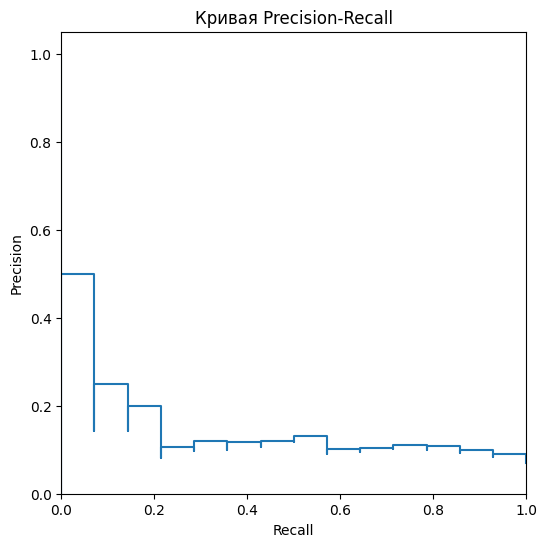

In [189]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')

plt.show()

Для порога 0.05 самый высокий показатель F1 и ROC-AUC

In [190]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('threshold=0.19')

In [191]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,DecisionTreeClassifier,0.23,0.71,0.41,upsampling
1,LogisticRegression,0.20,0.71,0.41,downsampled
2,DecisionTreeClassifier,0.21,0.69,0.37,class_weight
3,RandomForestClassifier,0.14,0.69,0.37,class_weight
4,RandomForestClassifier,0.11,0.68,0.36,upsampling
5,LogisticRegression,0.19,0.67,0.35,class_weight
6,LogisticRegression,0.16,0.67,0.35,threshold=0.19
7,LogisticRegression,0.17,0.63,0.27,upsampling
8,CatBoostClassifier,0.17,0.61,0.21,class_weight
9,DecisionTreeClassifier,0.20,0.60,0.19,downsampled


#### Модель Дерево решений 

In [192]:
%%time
1 + 1
model = DecisionTreeClassifier(max_depth=5)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.3, 0.01):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

Порог = 0.00 | Точность = 0.071, Полнота = 0.929, F1-мера = 0.133
Порог = 0.01 | Точность = 0.071, Полнота = 0.929, F1-мера = 0.133
Порог = 0.02 | Точность = 0.071, Полнота = 0.929, F1-мера = 0.133
Порог = 0.03 | Точность = 0.120, Полнота = 0.857, F1-мера = 0.211
Порог = 0.04 | Точность = 0.120, Полнота = 0.857, F1-мера = 0.211
Порог = 0.05 | Точность = 0.120, Полнота = 0.857, F1-мера = 0.211
Порог = 0.06 | Точность = 0.126, Полнота = 0.857, F1-мера = 0.220
Порог = 0.07 | Точность = 0.126, Полнота = 0.857, F1-мера = 0.220
Порог = 0.08 | Точность = 0.126, Полнота = 0.857, F1-мера = 0.220
Порог = 0.09 | Точность = 0.161, Полнота = 0.714, F1-мера = 0.263
Порог = 0.10 | Точность = 0.153, Полнота = 0.643, F1-мера = 0.247
Порог = 0.11 | Точность = 0.182, Полнота = 0.143, F1-мера = 0.160
Порог = 0.12 | Точность = 0.182, Полнота = 0.143, F1-мера = 0.160
Порог = 0.13 | Точность = 0.182, Полнота = 0.143, F1-мера = 0.160
Порог = 0.14 | Точность = 0.182, Полнота = 0.143, F1-мера = 0.160
Порог = 0.

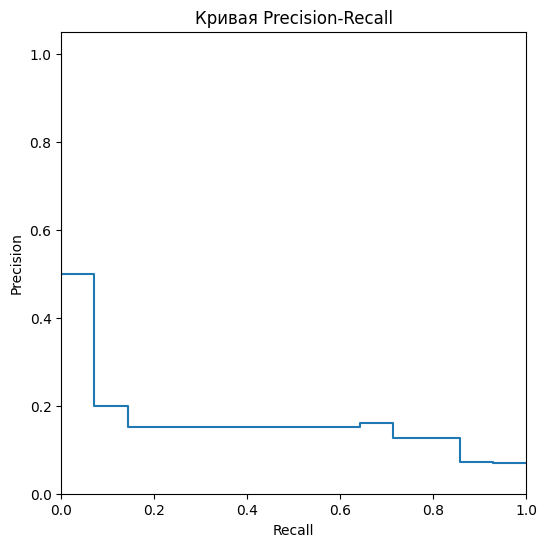

In [193]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

Для порога 0.4 самый высокий показатель F1

In [194]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('threshold=0.09')

In [195]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,DecisionTreeClassifier,0.26,0.73,0.46,threshold=0.09
1,DecisionTreeClassifier,0.23,0.71,0.41,upsampling
2,LogisticRegression,0.20,0.71,0.41,downsampled
3,DecisionTreeClassifier,0.21,0.69,0.37,class_weight
4,RandomForestClassifier,0.14,0.69,0.37,class_weight
5,RandomForestClassifier,0.11,0.68,0.36,upsampling
6,LogisticRegression,0.19,0.67,0.35,class_weight
7,LogisticRegression,0.16,0.67,0.35,threshold=0.19
8,LogisticRegression,0.17,0.63,0.27,upsampling
9,CatBoostClassifier,0.17,0.61,0.21,class_weight


#### Модель случайный лес

In [196]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.3, 0.01):
    predicted_valid = probabilities_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

Порог = 0.00 | Точность = 0.075, Полнота = 1.000, F1-мера = 0.139
Порог = 0.01 | Точность = 0.084, Полнота = 1.000, F1-мера = 0.155
Порог = 0.02 | Точность = 0.085, Полнота = 0.929, F1-мера = 0.156
Порог = 0.03 | Точность = 0.085, Полнота = 0.857, F1-мера = 0.155
Порог = 0.04 | Точность = 0.085, Полнота = 0.786, F1-мера = 0.154
Порог = 0.05 | Точность = 0.097, Полнота = 0.786, F1-мера = 0.173
Порог = 0.06 | Точность = 0.093, Полнота = 0.714, F1-мера = 0.165
Порог = 0.07 | Точность = 0.075, Полнота = 0.500, F1-мера = 0.131
Порог = 0.08 | Точность = 0.081, Полнота = 0.500, F1-мера = 0.140
Порог = 0.09 | Точность = 0.089, Полнота = 0.500, F1-мера = 0.151
Порог = 0.10 | Точность = 0.083, Полнота = 0.429, F1-мера = 0.140
Порог = 0.11 | Точность = 0.094, Полнота = 0.429, F1-мера = 0.154
Порог = 0.12 | Точность = 0.100, Полнота = 0.429, F1-мера = 0.162
Порог = 0.13 | Точность = 0.088, Полнота = 0.357, F1-мера = 0.141
Порог = 0.14 | Точность = 0.098, Полнота = 0.357, F1-мера = 0.154
Порог = 0.

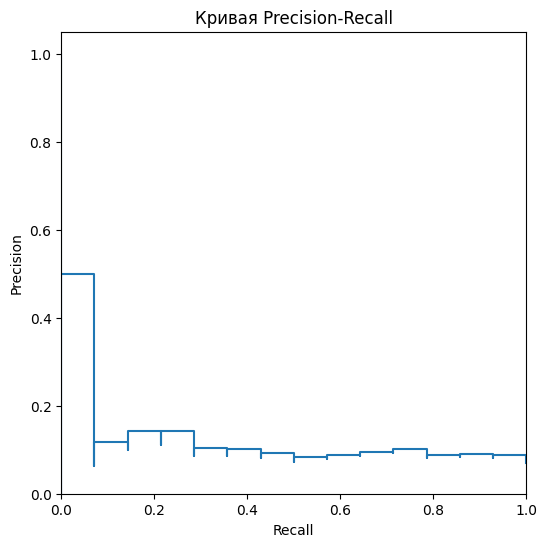

In [197]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

In [198]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('threshold=0.05')

In [199]:
%%time
1 + 1
model = CatBoostClassifier(verbose=100, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.3, 0.01):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

Learning rate set to 0.008283
0:	learn: 0.6849106	total: 893us	remaining: 893ms
100:	learn: 0.3375026	total: 69.9ms	remaining: 622ms
200:	learn: 0.2706317	total: 139ms	remaining: 554ms
300:	learn: 0.2403189	total: 211ms	remaining: 491ms
400:	learn: 0.2217593	total: 283ms	remaining: 422ms
500:	learn: 0.2073118	total: 377ms	remaining: 375ms
600:	learn: 0.1955484	total: 449ms	remaining: 298ms
700:	learn: 0.1836469	total: 518ms	remaining: 221ms
800:	learn: 0.1728261	total: 602ms	remaining: 150ms
900:	learn: 0.1628763	total: 695ms	remaining: 76.4ms
999:	learn: 0.1537580	total: 767ms	remaining: 0us
Порог = 0.00 | Точность = 0.070, Полнота = 1.000, F1-мера = 0.131
Порог = 0.01 | Точность = 0.071, Полнота = 1.000, F1-мера = 0.133
Порог = 0.02 | Точность = 0.081, Полнота = 1.000, F1-мера = 0.150
Порог = 0.03 | Точность = 0.088, Полнота = 0.929, F1-мера = 0.160
Порог = 0.04 | Точность = 0.094, Полнота = 0.857, F1-мера = 0.170
Порог = 0.05 | Точность = 0.106, Полнота = 0.857, F1-мера = 0.189
Поро

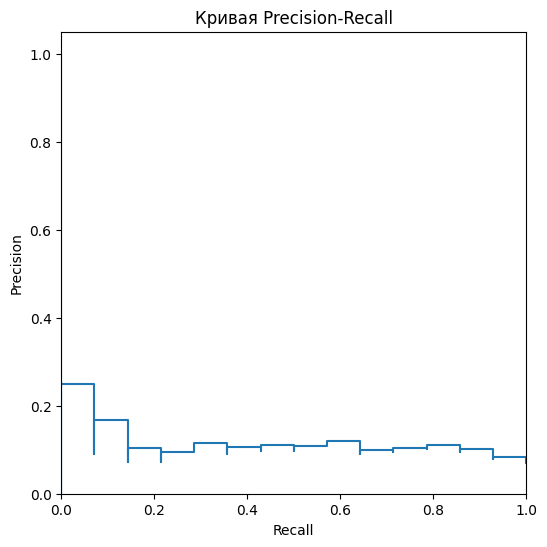

In [200]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

In [201]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('threshold=0.05')

In [202]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,DecisionTreeClassifier,0.26,0.73,0.46,threshold=0.09
1,DecisionTreeClassifier,0.23,0.71,0.41,upsampling
2,LogisticRegression,0.20,0.71,0.41,downsampled
3,DecisionTreeClassifier,0.21,0.69,0.37,class_weight
4,RandomForestClassifier,0.14,0.69,0.37,class_weight
5,RandomForestClassifier,0.11,0.68,0.36,upsampling
6,LogisticRegression,0.19,0.67,0.35,class_weight
7,LogisticRegression,0.16,0.67,0.35,threshold=0.19
8,CatBoostClassifier,0.19,0.65,0.31,threshold=0.05
9,LogisticRegression,0.17,0.63,0.27,upsampling


### Вывод

<div class="alert alert-info"> <b>
У нас определилась самая удачная модели - DecisionTreeClassifier с лучшей F1-мерой и мерой ROC-AUC полученной с параметром threshold=0.09. Попробуем подобрать для нее оптимальные гиперпараметры.

    1. Кроме того, мы выявили что при наличии дисбаланса для нашей задачи, лучше всего подходит параметр изменение порога для DecisionTreeClassifier и LogisticRegression.
    2. Увеличение выборки показало себя лучше чем ее уменьшение. 
    3. class_weight показал себя средне
</div>


### Подбор гиперпараметров

In [203]:
# Задаем параметры для поиска по сетке
parameters = {
    'max_depth': range(1,10),
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,5),
    'max_features': ['sqrt', 'log2', None]
}

# Создаем модель
clf = DecisionTreeClassifier(random_state=453)

# Запускаем поиск по сетке
grid_search = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(features_train, target_train)

# Выводим лучшие параметры и лучший ROC-AUC score
print('Best parameters:', grid_search.best_params_)
print('Best ROC-AUC score (training):', grid_search.best_score_)

auc_roc = grid_search.best_score_
gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))

Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3}
Best ROC-AUC score (training): 0.6703913939700543
Gini Index = 0.341



## Проверяем модель на тестовой выборке

In [204]:
tabl_model = []
tabl_prec = []
tabl_not = []
tabl_roc_auc = []
tabl_gini = []
tabl_params = []

In [205]:
# Обучаем модель с лучшими параметрами
model_best = DecisionTreeClassifier(**grid_search.best_params_, random_state=453)
model_best.fit(features_train, target_train)

# Получаем предсказанные вероятности
probabilities = model_best.predict_proba(features_test)[:, 1]

# Устанавливаем порог и преобразуем вероятности в предсказанные классы
threshold = 0.09
predicted = (probabilities >= threshold).astype('int')

# Получаем ROC-AUC и Gini Index для предсказаний с учетом порога
roc_auc = roc_auc_score(target_test, probabilities)
gini = 2 * roc_auc - 1
print("ROC-AUC: {:.3f}".format(roc_auc))
print("Gini Index: {:.3f}".format(gini))

# Вычисляем и печатаем F1-score
f1 = f1_score(target_test, predicted)
print("F1-score: {:.3f}".format(f1))

ROC-AUC: 0.686
Gini Index: 0.372
F1-score: 0.352


In [206]:
tabl_prec.append(round(f1, 2))
tabl_roc_auc.append(round(roc_auc, 2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('test')
tabl_gini.append(round(gini, 2))
tabl_params.append(grid_search.best_params_)


In [207]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 
                              'Gini Index':tabl_gini, 'Notice': tabl_not, 'params':tabl_params}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice,params
0,DecisionTreeClassifier,0.35,0.69,0.37,test,"{'max_depth': 3, 'max_features': 'sqrt', 'min_..."


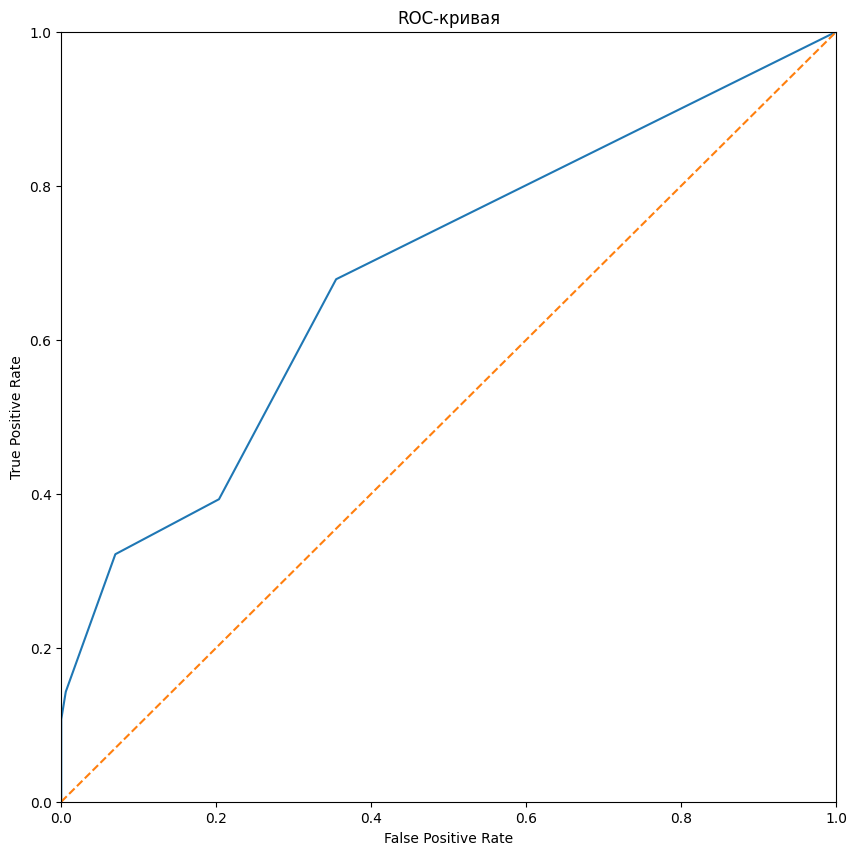

AUC: 0.6859426910299005


In [208]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities)

print("AUC:", auc_roc)

Модель получше константной

## Важность признаков

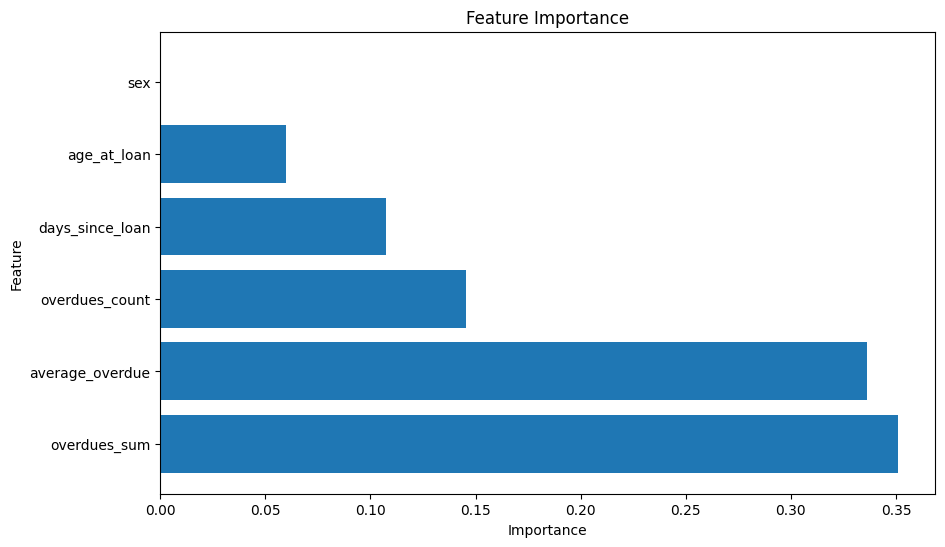

In [209]:
# Получаем важности признаков
importances = model_best.feature_importances_

# Создаем DataFrame с важностями признаков
feature_importance_df = pd.DataFrame({'Feature': features_train.columns, 'Importance': importances})

# Сортируем по убыванию важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Создаем график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Вывод 

**Согласно анализу, самые важные признаки, на которые стоит обратить внимание, это:**  
  
1. *overdues_sum*: Общая сумма просроченных дней платежей клиента. Этот признак является сильным индикатором плохой кредитной истории и может быть полезным для прогнозирования типа кредита.  
  
2. *average_overdue*: Средний колмчество дней просроченного платежа клиента. Этот признак также может быть информативным при прогнозировании типа кредита.
  
3. *overdues_count*: Количество просроченных платежей клиента. Этот признак указывает на активность клиента в погашении кредитных обязательств и может быть полезным для предсказания типа кредита.  
  
**Для прогнозирования проблемных кредитов можно использовать модель**    
*model_best = DecisionTreeClassifier(**grid_search.best_params_, random_state=453)  
Best parameters: "{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3}"*  
 
**С метриками**   
*ROC-AUC: 0.686  
Gini Index: 0.372  
F1-score: 0.352*  
  
Эти метрики позволяют оценить качество модели и ее способность предсказывать тип кредита.  

***Проблемы построения модели:***  
  
1. Малое количество признаков: У нас ограниченный набор признаков, которые могут быть использованы для построения модели. Это может ограничить способность модели к полному и точному прогнозированию типа кредита. Возможно, добавление дополнительных информативных признаков может улучшить производительность модели.
  
2. Недостаток данных: Если у вас мало данных, особенно примеров положительного класса (в вашем случае - проблемных кредитов), это может затруднить обучение хорошей модели. Модели машинного обучения обычно работают лучше с большим количеством данных. 
   
3. Отсутствие уникального идентификатора кредита: В данных отсутствует прямой способ связать просрочки с конкретными кредитами. Это ограничивает нашу способность более точно анализировать и предсказывать связь между просрочками и типом кредита. Вместо этого мы предполагаем, что общая история просрочек клиента применима ко всем его кредитам. Это может вносить некоторую неопределенность и потенциально снижать точность предсказания модели.  

В целом, необходимо учитывать эти проблемы при построении модели и принимать соответствующие меры для минимизации их влияния на качество и интерпретируемость модели.  

In [210]:
table_models.to_csv('результаты_тестирования.csv', index=False)
